In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from scipy.stats import random_correlation

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from plotnine import *

### 1 Continuous Targets

Modify generate Data

In [2]:
def generate_data(n: int = 1000,
                  p: int = 10,
                  beta_range: list[float] = [0, 2],
                  sigma: float = 1.0,
                  corr: np.array = None) -> tuple:
    """Generate random features and labels using a linear regression model.

    Arguments:
    n (int): The number of samples.
    p (int): The number of parameters.
    beta_range (list[float]): The lower and upper bounds of the coefficients.
    corr (np.array): A correlation structure to impose on the features.

    Returns:
    A tuple (X, y, beta) containing the feature matrix, labels and true betas.
    """
    
    np.random.seed(13)
    
    # Generate random features.
    p = int(p)
    if corr is None:
        covar = np.diag(np.full(p, sigma))
    else:
        assert(corr.shape[0] == p)
        assert(corr.shape[1] == p)
        covar = corr * sigma
    X = np.random.multivariate_normal(np.zeros(p), covar, n)

    # Generate random coefficients.
    assert(len(beta_range) == 2)
    assert(beta_range[0] <= beta_range[1])
    beta = np.random.uniform(size=p, low=beta_range[0], high=beta_range[1])

    # Generate normally distributed noise.
    noise = np.random.normal(loc=0, scale=sigma, size=n)

    # Generate targets based on the linear relationship y = X𝝱 + 𝞮
    y = np.dot(X, beta) + noise

    return X, y, beta

def generate_correlation(p: int = 10) -> np.array:
    """Generate a correlation matrix based on a random vector of eigenvalues.

    Arguments:
    p (int): Dimensionality of the correlation matrix.

    Returns:
    A correlation matrix with shape (p, p).
    """

    p = int(p)
    assert(p > 1)
    # Generate some uniform random variables.
    u = np.random.uniform(size=p)
    # Scale the random numbers so that they sum to p.
    eigen = u * p / np.sum(u)
    # Return correlation.
    return random_correlation.rvs(eigen)

In [3]:
n = 1000
p = 10

corr = generate_correlation(p = p)
X, y, beta = generate_data(n = n, p = p, corr = corr)

### 1.1 Create metrics functions (15pts)


In [4]:
def rsquared(y: np.array, yhat: np.array) -> float:
    """
    Parameters:
    - y: np.array
        Observed values.
    - yhat: np.array
        Predicted values.

    Returns:
    - float
        R-squared value.
    """
    # Calculate the mean of the observed values
    y_mean = np.mean(y)

    # Calculate the total sum of squares
    ss_total = np.sum((y - y_mean) ** 2)

    # Calculate the residual sum of squares
    ss_residual = np.sum((y - yhat) ** 2)

    # Calculate R-squared
    r_squared = 1 - (ss_residual / ss_total)

    return r_squared


In [5]:
def mae(y: np.array, yhat: np.array) -> float:
    """
    Calculate Mean Absolute Error (MAE) between observed and predicted values.

    Parameters:
    - y: np.array
        Observed values.
    - yhat: np.array
        Predicted values.

    Returns:
    - float
        Mean Absolute Error.
    """
    # Calculate the absolute differences between observed and predicted values
    ae = np.abs(y - yhat)

    return np.mean(ae)

In [6]:
def mse(y: np.array, yhat: np.array) -> float:
    """
    Calculate Mean Squared Error (MSE) between observed and predicted values.

    Parameters:
    - y: np.array
        Observed values.
    - yhat: np.array
        Predicted values.

    Returns:
    - float
        Mean Squared Error.
    """
    # Calculate the squared differences between observed and predicted values
    se = (y - yhat) ** 2

    return np.mean(se)

In [7]:
def rmse(y: np.array, yhat: np.array) -> float:
    """
    Calculate Root Mean Squared Error (RMSE) between observed and predicted values.

    Parameters:
    - y: np.array
        Observed values.
    - yhat: np.array
        Predicted values.

    Returns:
    - float
        Root Mean Squared Error.
    """
    # Calculate the squared differences between observed and predicted values
    se = (y - yhat) ** 2

    # Calculate the mean squared error
    mse = np.mean(se)

    return np.sqrt(mse)

Validation with sklearn

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Generate some example data
np.random.seed(42)
y_true = np.random.rand(100)
y_pred = y_true + 0.1 * np.random.randn(100)  # Adding some random noise

# Validate with scikit-learn functions
sklearn_mae = mean_absolute_error(y_true, y_pred)
sklearn_mse = mean_squared_error(y_true, y_pred)
sklearn_rmse = np.sqrt(sklearn_mse)
sklearn_r2 = r2_score(y_true, y_pred)

# Validate with your custom functions
custom_mae = mae(y_true, y_pred)
custom_mse = mse(y_true, y_pred)
custom_rmse = rmse(y_true, y_pred)
custom_r2 = rsquared(y_true, y_pred)

# Compare the results
print(f"MAE: sklearn={sklearn_mae}, custom={custom_mae}")
print(f"MSE: sklearn={sklearn_mse}, custom={custom_mse}")
print(f"RMSE: sklearn={sklearn_rmse}, custom={custom_rmse}")
print(f"R-squared: sklearn={sklearn_r2}, custom={custom_r2}")

MAE: sklearn=0.07211163129546802, custom=0.07211163129546802
MSE: sklearn=0.008251067799079387, custom=0.008251067799079387
RMSE: sklearn=0.09083538847321228, custom=0.09083538847321228
R-squared: sklearn=0.9058258004700179, custom=0.9058258004700179


### 1.2 Lasso regression (15 pts)

Using your simulated data in the introduction of this problem perform the following:
- Use alpha values given by np.arange(0.00005, 0.04, 0.005).
- Use train_test_split on (y, X) to create a 80% train/val, 20% test set. 
- Perform a KFold cross validation on the train/val using:
    - cv = KFold(n_splits = 5, random_state = 13, shuffle = True)
    
- For each fold perform Lasso regression for a given alpha and compute R2, MAE, and RMSE.
- Take the average of each metric across folds (see get_cross_valid_scores from  Homework 1 solutions as an example).


In [9]:
# alpha values given by np.arange(0.00005, 0.04, 0.005)
alpha = np.arange(0.00005, 0.04, 0.005)

In [10]:
# train_test_split on (y, X) to create a 80% train/val, 20% test set. 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [11]:
def get_cross_valid_scores(
    cv: KFold,
    X: np.array,
    Y: np.array,
    alpha: float = 0.001) -> float:
    """A more correct way of getting the cross-validation R^2 values.
    Arguments:
        cv (KFold): An object of class 'KFold'.
        X (np.array): A numpy array with dimensions (n, p) containing the features.
        Y (np.array): A numpy array with dimensions (n, ) containing the targets.
        alpha (float): The regularization parameter used in the Lasso.
    Returns:
        An average of R^2 values across the k folds.
    """
    r2_scores = []
    mae_scores = []
    rmse_scores = []

    # Check if this is a data frame and convert if necessary.
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # Loop over splits.
    for train_index, test_index in cv.split(X.values):
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Fit Lasso to scaled training data.
        reg = Lasso(alpha=alpha).fit(X_train, Y_train)

        # Predict on test.
        Y_test_hat = reg.predict(X_test)

        # Compute R^2 and append to return array.
        r2 = rsquared(Y_test, Y_test_hat)
        r2_scores.append(r2)

        # Compute MAE and append to return array.
        mae_score = mae(Y_test, Y_test_hat)
        mae_scores.append(mae_score)

        # Compute MAE and append to return array.
        rmse_score = rmse(Y_test, Y_test_hat)
        rmse_scores.append(rmse_score)

    return np.mean(r2_scores), np.mean(mae_scores), np.mean(rmse_scores)

In [12]:
cv = KFold(n_splits = 5, random_state = 13, shuffle = True)
scores = []

for a in alpha:
    r2_score, mae_score, rmse_score = get_cross_valid_scores(cv, X_train_val, y_train_val, alpha=a)
    print(f"Alpha:{round(a,5)} R-squared: {r2_score} MAE:{mae_score} RMSE:{rmse_score}")
    scores.append([str(round(a,5)), r2_score, mae_score, rmse_score])
    

Alpha:5e-05 R-squared: 0.93176001341329 MAE:0.7847758531682717 RMSE:0.996653122415631
Alpha:0.00505 R-squared: 0.9317367994570132 MAE:0.7852537053434198 RMSE:0.996839451387881
Alpha:0.01005 R-squared: 0.9316558300481358 MAE:0.7861247980718581 RMSE:0.99744158521037
Alpha:0.01505 R-squared: 0.9315168845906365 MAE:0.7874723862247871 RMSE:0.9984597704342868
Alpha:0.02005 R-squared: 0.9313199637108284 MAE:0.7892511606295791 RMSE:0.9998928054902846
Alpha:0.02505 R-squared: 0.9310650677512852 MAE:0.7911708686275711 RMSE:1.0017389983736702
Alpha:0.03005 R-squared: 0.9307521962874615 MAE:0.793275793433374 RMSE:1.0039961796684809
Alpha:0.03505 R-squared: 0.9303813492539019 MAE:0.7955847699218412 RMSE:1.006661705617367


### 1.3 Determine the best alpha for each metric (10 pts)


In [13]:
df_score = pd.DataFrame(scores, columns=['alpha','r2','mae','rmse'])
df_score

,alpha,r2,mae,rmse
0,5e-05,0.931760,0.784776,0.996653
1,0.00505,0.931737,0.785254,0.996839
2,0.01005,0.931656,0.786125,0.997442
3,0.01505,0.931517,0.787472,0.998460
4,0.02005,0.931320,0.789251,0.999893
5,0.02505,0.931065,0.791171,1.001739
6,0.03005,0.930752,0.793276,1.003996
7,0.03505,0.930381,0.795585,1.006662


Create a plot of your 3 metrics vs. each alpha.

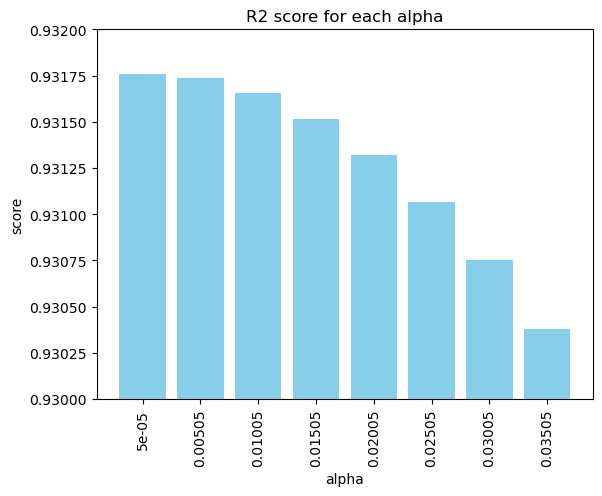

In [14]:
# Create a bar plot
plt.bar(df_score['alpha'], df_score['r2'], color='skyblue')

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('R2 score for each alpha')

plt.ylim(.93, .932)

# Display the plot
plt.show()

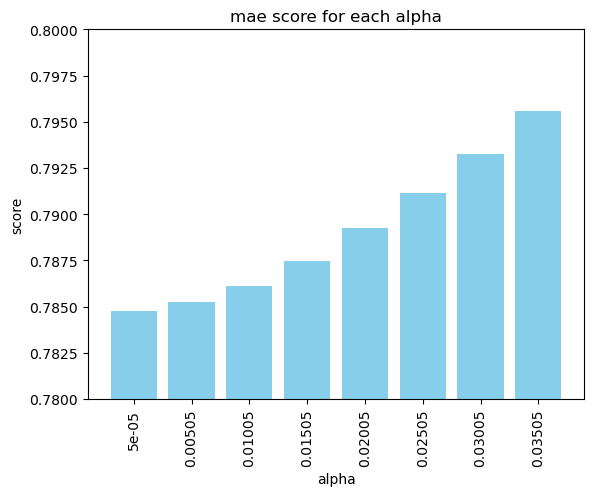

In [15]:
# Create a bar plot
plt.bar(df_score['alpha'], df_score['mae'], color='skyblue')

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('mae score for each alpha')

plt.ylim(.78, .80)

# Display the plot
plt.show()

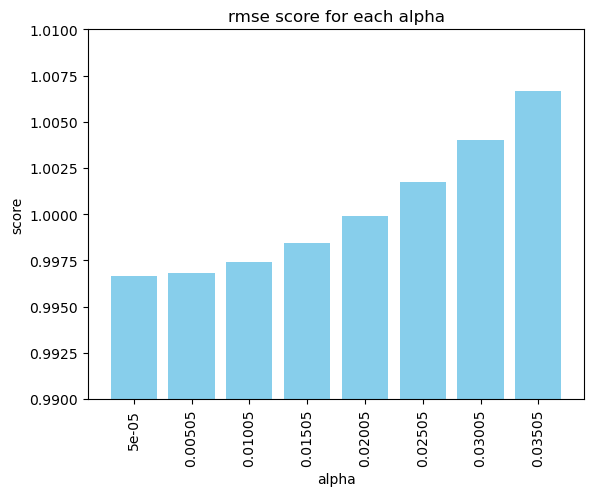

In [16]:
# Create a bar plot
plt.bar(df_score['alpha'], df_score['rmse'], color='skyblue')

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('rmse score for each alpha')

plt.ylim(.99, 1.01)

# Display the plot
plt.show()

Which alpha is the best for each metric?

Ans:
- R square: 0.00005
- MAE: 0.00005
- RMSE: 0.00005

Do they agree? If not, explain why.

Ans: Yes they agree

### 1.4 Compute metrics on test (10 pts)

Use your best alpha(s) to report your three metrics on the test.

In [17]:
# R square
reg = Lasso(alpha=0.00005).fit(X_train_val, y_train_val)
# Predict on test.
Y_test_hat = reg.predict(X_test)

# Compute R^2 and append to return array.
r2 = rsquared(y_test, Y_test_hat)
r2

0.935982928268013

In [18]:
# MAE
# Compute MAE and append to return array.
mae_test = mae(y_test, Y_test_hat)
mae_test

0.7566508432943244

In [19]:
# RMSE
# Compute MAE and append to return array.
mae_test = rmse(y_test, Y_test_hat)
mae_test

0.9576522655911064

How different are they from training (problem 1.2)?

- R square  Training: 0.931760 / Testing: 0.93598
- MAE       Training: 0.784776 / Testing: 0.75665
- RMSE      Training: 0.996653 / Testing: 0.95765

If you came up with different models (i.e. a different alpha for each metric), create predictions from each model. Produce a pairwise correlation matrix of the three outcomes and comment. If you found that all three metrics agreed on the same alpha, comment on that as well.

They all have same alpha, meaning that using different matrics all have same result on choosing alpha

### 2.1 Create metrics functions (15 pts)

In [20]:
def roc_score(y: np.array, yhat: np.array, thresh: float = 0.5) -> tuple:
    """
    Compute False Positive Rate (FPR) and True Positive Rate (TPR) for a given threshold.

    Parameters:
    - y: np.array, actual labels (binary)
    - yhat: np.array, predicted probabilities or labels
    - thresh: float, threshold for classifying positive/negative

    Returns:
    Tuple of False Positive Rate (FPR) and True Positive Rate (TPR)
    """
    y_pred = (yhat >= thresh).astype(int)
    total_positive = np.sum(y)
    total_negative = len(y) - total_positive
    true_positive = np.sum((y == 1) & (y_pred == 1))
    false_positive = np.sum((y == 0) & (y_pred == 1))

    fpr = false_positive / total_negative
    tpr = true_positive / total_positive

    return (fpr, tpr)

In [21]:
def precision(y: np.array, yhat: np.array, thresh: float = 0.5) -> float:
    """
    Compute Precision for a given threshold.

    Parameters:
    - y: np.array, actual labels (binary)
    - yhat: np.array, predicted probabilities or labels
    - thresh: float, threshold for classifying positive/negative

    Returns:
    Precision as a float
    """
    y_pred = (yhat >= thresh).astype(int)
    true_positive = np.sum((y == 1) & (y_pred == 1))
    false_positive = np.sum((y == 0) & (y_pred == 1))

    if true_positive + false_positive == 0:
        return 0.0
    else:
        precision_value = true_positive / (true_positive + false_positive)
        return precision_value

In [22]:
def recall(y: np.array, yhat: np.array, thresh: float = 0.5) -> float:
    """
    Compute Recall for a given threshold.

    Parameters:
    - y: np.array, actual labels (binary)
    - yhat: np.array, predicted probabilities or labels
    - thresh: float, threshold for classifying positive/negative

    Returns:
    Recall as a float
    """
    y_pred = (yhat >= thresh).astype(int)
    true_positive = np.sum((y == 1) & (y_pred == 1))
    false_negative = np.sum((y == 1) & (y_pred == 0))

    if true_positive + false_negative == 0:
        return 0.0
    else:
        recall_value = true_positive / (true_positive + false_negative)
        return recall_value

In [23]:
def f_score(y: np.array, yhat: np.array, thresh: float = 0.5, beta: float = 1.) -> float:
    """
    Compute Fβ Score for a given threshold.

    Parameters:
    - y: np.array, actual labels (binary)
    - yhat: np.array, predicted probabilities or labels
    - thresh: float, threshold for classifying positive/negative
    - beta: float, positive constant to control the tradeoff between precision and recall

    Returns:
    Fβ Score as a float
    """
    y_pred = (yhat >= thresh).astype(int)
    true_positive = np.sum((y == 1) & (y_pred == 1))
    false_positive = np.sum((y == 0) & (y_pred == 1))
    false_negative = np.sum((y == 1) & (y_pred == 0))

    if true_positive + false_positive == 0:
        precision_value = 0
    else:   precision_value = true_positive / (true_positive + false_positive)
    if true_positive + false_negative == 0:
        recall_value = 0.0
    else:   recall_value = true_positive / (true_positive + false_negative)

    if precision_value + recall_value == 0:
        return 0.0
    else:
        f_beta_score = (1 + beta**2) * (precision_value * recall_value) / ((beta**2 * precision_value) + recall_value)
        return f_beta_score

sklearn debug

In [24]:
from sklearn.metrics import roc_curve, precision_score, recall_score, fbeta_score

# Generate some example data
np.random.seed(42)
y_actual = np.random.randint(2, size=100)
y_predicted = np.random.rand(100)

# Checking roc_score:
sk_fpr, sk_tpr, thresh = roc_curve(y_actual, y_predicted)

i = 0
for t in thresh:
    fpr, tpr = roc_score(y_actual, y_predicted, t)
    assert np.allclose(fpr, sk_fpr[i]), "ROC FPR values are not close"
    assert np.allclose(tpr, sk_tpr[i]), "ROC TPR values are not close"
    i += 1

# Checking precision:
prec = precision(y_actual, y_predicted)
sk_prec = precision_score(y_actual, (y_predicted >= 0.5).astype(int))
assert np.isclose(prec, sk_prec), "Precision values are not close"

# Checking recall:
rec = recall(y_actual, y_predicted)
sk_rec = recall_score(y_actual, (y_predicted >= 0.5).astype(int))
assert np.isclose(rec, sk_rec), "Recall values are not close"

# Checking f_score:
f_beta = f_score(y_actual, y_predicted, beta=2)
sk_f_beta = fbeta_score(y_actual, (y_predicted >= 0.5).astype(int), beta=2)
assert np.isclose(f_beta, sk_f_beta), "F2 Score values are not close"

print("All functions passed the sklearn validation.")

All functions passed the sklearn validation.


### 2.1 Compute your metrics some sample data (20 pts)

Using the thresholds [1.863, 0.863, 0.83 , 0.788, 0.601, 0.323, 0.28 , 0.277], construct the ROC, Precision, Recall, and F1 score for the following data:

In [25]:
y = np.array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1])
yhat = np.array([0.367, 0.863, 0.830, 0.277, 0.788, 0.348, 0.601, 0.441, 0.323, 0.280])
roc_thresholds = [1.863, 0.863, 0.83 , 0.788, 0.601, 0.323, 0.28 , 0.277]
thresholds = [0.277, 0.28, 0.323, 0.348, 0.367, 0.441, 0.601, 0.788, 0.83, 0.863]
fpr = []
tpr = []
prec_l = []
rec_l = []

for t in roc_thresholds:
    roc = roc_score(y, yhat, t)
    print(f'{t} ROC:[{round(roc[0],4),round(roc[1],4)}]')
    fpr.append(roc[0])
    tpr.append(roc[1])

print('\n')

for t in thresholds:
    roc = roc_score(y, yhat, t)
    prec = precision(y, yhat, t)
    rec = recall(y, yhat, t)
    f1 = f_score(y, yhat, t)
    print(f'{t} Precision:{round(prec,4)} Recall:{round(rec,4)} F1:{round(f1,4)}')
    fpr.append(roc[0])
    tpr.append(roc[1])
    prec_l.append(prec)
    rec_l.append(rec)

1.863 ROC:[(0.0, 0.0)]
0.863 ROC:[(0.0, 0.25)]
0.83 ROC:[(0.0, 0.5)]
0.788 ROC:[(0.1667, 0.5)]
0.601 ROC:[(0.1667, 0.75)]
0.323 ROC:[(0.8333, 0.75)]
0.28 ROC:[(0.8333, 1.0)]
0.277 ROC:[(1.0, 1.0)]


0.277 Precision:0.4 Recall:1.0 F1:0.5714
0.28 Precision:0.4444 Recall:1.0 F1:0.6154
0.323 Precision:0.375 Recall:0.75 F1:0.5
0.348 Precision:0.4286 Recall:0.75 F1:0.5455
0.367 Precision:0.5 Recall:0.75 F1:0.6
0.441 Precision:0.6 Recall:0.75 F1:0.6667
0.601 Precision:0.75 Recall:0.75 F1:0.75
0.788 Precision:0.6667 Recall:0.5 F1:0.5714
0.83 Precision:1.0 Recall:0.5 F1:0.6667
0.863 Precision:1.0 Recall:0.25 F1:0.4


### 2.2 Plot the curves and determine AUROC and AUPRC (10 pts)

Plot the curves and determine AUROC and AUPRC for the data in 2.1. You can use sklearn.auc for this exercise. Comment on your findings.

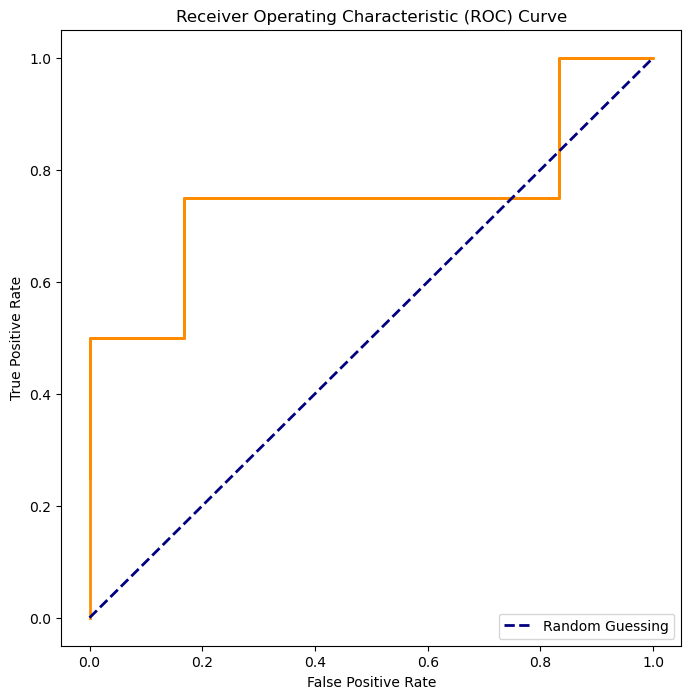

In [26]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Finding: For some certain roc thresholds, the performance is worse than random guessing.

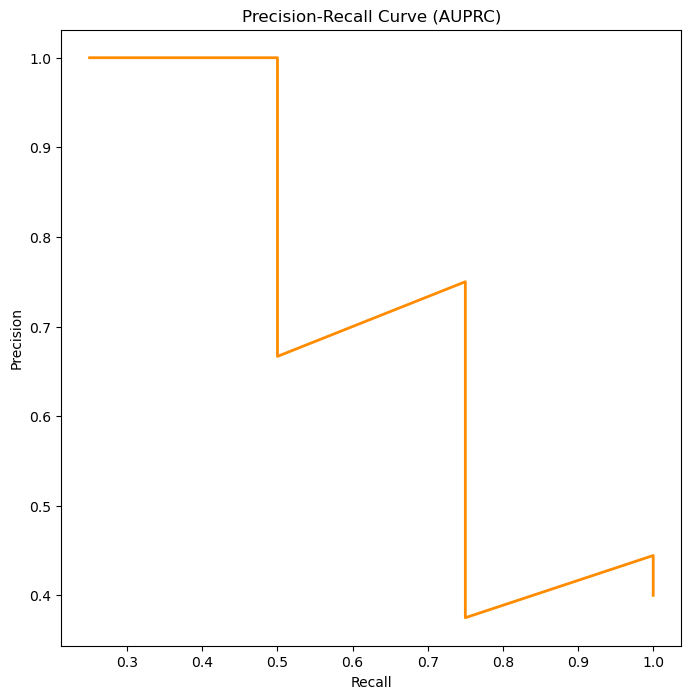

In [27]:
plt.figure(figsize=(8, 8))
plt.plot(rec_l, prec_l, color='darkorange', lw=2)
# plt.step(rec_l, prec_l, color='b', alpha=0.2, where='post')
# plt.fill_between(rec_l, prec_l, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUPRC)')
plt.show()

Finding: The precision and recall is a kind of tradeoff. So the line looks kind of downward-sloping.